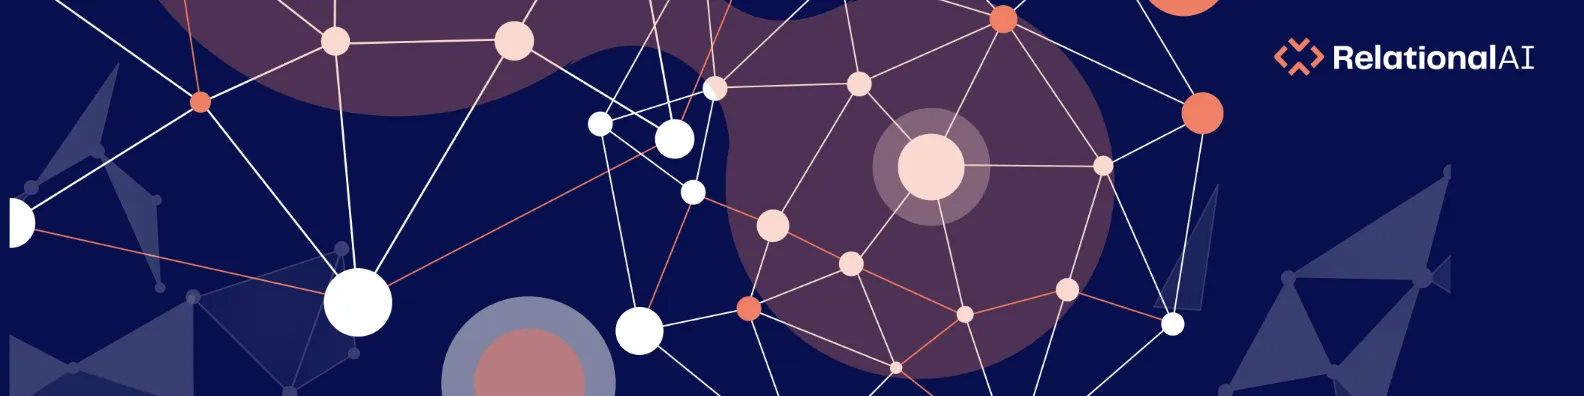

# Network Connectivity using RelationalAI

## Overview
In this notebook, we will explore how to utilize RelationalAI to execute weakly connected component algorithm for identifying groups of towers that are within a proximity of less than 5 miles from each other.

## What you will learn
- How to run all sorts of graph algorithms on our data, where it already lives, to discover new insights.
- How to visualize graphs.
- How thanks to native applications with Snowpark Container Services, we can do all of this within the Data Cloud!

***

## Let's get started!
We start by importing all the Python packages and modules that we will need.

In [1]:
import json
import pandas as pd

import relationalai as rai
from relationalai.clients.snowflake import Snowflake
from relationalai.std import aggregates, rel, Vars, alias
from relationalai.std.graphs import Graph

from snowflake.snowpark.session import Session

Let's define two helper functions:
- distance_between_coordinates 
- generate_distinct_colors

In [2]:
def distance_between_coordinates(lat_a, lat_b, lng_a, lng_b):    
    # Converting longitude from degrees to radians and calculating the difference 
    d_long = rel.deg2rad(lng_a) - rel.deg2rad(lng_b)
    
    # Converting latitude from degrees to radians and calculating the difference 
    d_lat = rel.deg2rad(lat_a) - rel.deg2rad(lat_b)

    a = rel.power(rel.sin(d_lat / 2), 2) + \
        rel.cos(rel.deg2rad(lat_a)) * \
        rel.cos(rel.deg2rad(lat_b)) * \
        rel.power(rel.sin(d_long / 2), 2)
    
    # Calculating the Angular distance
    c = 2 * rel.atan2(rel.sqrt(rel.abs(a)), rel.sqrt(rel.abs(1 - a)))
    
    # Multiplying by radius   
    return c * 6373.0

In [3]:
def generate_distinct_colors(n):
    # Predefined set of visually distinct colors
    distinct_colors = [
        "#008080", "#E6BEFF", "#9A6324", "#FFFAC8", "#800000", 
        "#E6194B", "#3CB44B", "#FFE119", "#4363D8", "#F58231", 
        "#AA6E28", "#808000", "#FFD8B1", "#000075", "#808080", 
        "#911EB4", "#46F0F0", "#F032E6", "#BCF60C", "#FABEBE", 
        "#FFFFFF", "#000000"
    ]
        
    # If n is greater than the number of predefined distinct colors, repeat the list
    if n > len(distinct_colors):
        return distinct_colors * (n // len(distinct_colors)) + distinct_colors[:n % len(distinct_colors)]
    else:
        return distinct_colors[:n]

### Define Model in RelationalAI
Let's define our model object. **Models** represent collections of objects. **Objects**, like Python objects, have **types** and **properties**, which we will define in a bit.

In [4]:
model = rai.Model("network_connectivity_demo_v1")

### Referencing Snowflake Data
Due to RelationalAI's tight integration with Snowflake, we can refer to data that we are streaming to our RelationalAI database by simply referring to sf.<my_database>.<my_schema.my_table>.

Let's run a small query to understand the shape of our data.

In [5]:
sf = Snowflake(model)
Record = sf.TELECOM.TOWER_DEMO.TOWER_DATA_V2

In [38]:
# Check Data
with model.query() as select:
    r = Record()
    rank = aggregates.top(5, r.tower_id, r)
    response = select(
        alias(rank, "index"),
        r.tower_name,
        r.status,
        r.status_message,
        r.lat,
        r.lon,
        r.last_comm,
        r.maintenance_due,
        r.tower_id,
    )
response

### Type Declarations
Now that we know how to refer to our data within RAI, let's define our **Types**. Types are collections of objects. You create then using the `model.Type()` method, which returns an instance of the `Type` class.

In [7]:
Tower = model.Type("Tower")
Connection = model.Type("Connection")

## Weaving data into our Model
It's time to start weave our data into our model. We do this by writing some rules. **Rules describe objects in a model and the relationships between them**. They are created using the `model.rule()` context manager.

### Defining Tower
This rule adds an object to the `Tower` type for each occurrence of a unique `tower_id` and `status`. Let's run a query to see how many customers we have in our dataset.

In [8]:
# Define Tower Type
with model.rule():
    r = Record()
    Tower.add(tower_id=r.tower_id, status=r.status, lat=r.lat, lon=r.lon)

# Check the total number of Towers
with model.query() as select:
    tower = Tower()
    num_records = aggregates.count(tower)
    result = select(num_records)

result

### Defining Connections
We establish a `Connection` between two towers if the distance between them is less than 5 miles.

In [9]:
# Create a Rule to Connect Towers within 5 Miles Distance
with model.rule():
    r1 = Record()
    r2 = Record()
    
    # Ensure different tower IDs
    r1.tower_id != r2.tower_id
    
    # Calculate distance
    dist = distance_between_coordinates(
        r1.lat,
        r2.lat,
        r1.lon,
        r2.lon
    )
    
    # Filter with distance threshold
    dist < 5
    
    # Define Connection between r1 and r2
    Connection.add(
        tower1=Tower(tower_id=r1.tower_id),
        tower2=Tower(tower_id=r2.tower_id),
        distance=dist
    )

### Preparing The Graph

Let's build out our network graph. Our **nodes** are towers. We use the relevant connections between towers, that we have derived earlier, as the **edges** of our graph.

In [10]:
network_graph = Graph(model, undirected=True, with_isolated_nodes=True)

In [11]:
# Add nodes to the graph
with model.rule():
    tower = Tower()
    network_graph.Node.add(tower)

In [12]:
# Add edges to the graph between towers
with model.rule():
    conn = Connection()
    network_graph.Edge.add(
        conn.tower1,
        conn.tower2,
        distance=conn.distance
    )

### Finding Group of Towers
Let's use the **weakly connected component** algorithm to find group of towers within our graph.

In [13]:
with model.rule():
    tower = Tower()
    component = network_graph.compute.weakly_connected_component(tower)
    tower.set(component=component)

In [14]:
with model.rule():
    tower = Tower()
    network_graph.Node.add(
        tower,
        component=tower.component,
        tower_id=tower.tower_id,
        status=tower.status
    )

In [15]:
with model.query() as select:
    tower = Tower()
    num_records = aggregates.count(tower.component)
    result = select(num_records)
result

### Visualize Graph

In [16]:
data = network_graph.fetch()

num_nodes = len(data["nodes"])
num_edges = len(data["edges"])
print(f"Number of nodes: {num_nodes}, Number of edges: {num_edges}")

Number of nodes: 100, Number of edges: 406


In [17]:
component_set = {node['component'] for node in data['nodes'].values() if 'component' in node}
num_component = len(component_set)
print(f"Number of components: {num_component}")

random_colors = generate_distinct_colors(num_component)

component_colors = {}
for i, component in enumerate(component_set):
    component_colors[component] = random_colors[i]

Number of components: 22


In [18]:
figure = network_graph.visualize(
    three=True,
    node_label_size_factor=1.9,
    use_links_force=True,
    node_hover_neighborhood=True,
    style={
    "node": {
        "color": lambda x : component_colors[x['component']] if x['status']=='Online' else 'black',
        "hover": lambda x : f"Tower: {x['tower_id']} - Status: {x['status']}"
    },
    "edge": {
        "opacity": 0.8,
        "color": "#ccc",
        "hover": lambda x : 'distance: {:.2f}'.format(x['distance'])
    }
})

In [19]:
figure

In [22]:
figure.export_html('./app/graph.html')

### Save enhanced data to Snowflake table
We will use Snowpark to save data into a table

In [23]:
with open("../../../connection.json", "r") as connection_file:
    connection_parameters = json.load(connection_file)
    
session = Session.builder.configs(connection_parameters).create()

session.sql("USE DATABASE TELECOM").collect()
session.sql("USE SCHEMA TOWER_DEMO").collect()

[Row(status='Statement executed successfully.')]

#### Save Components

In [24]:
with model.query() as select:
    tower = Tower()
    response = select(
        alias(tower.tower_id, "TOWER_ID"),
        alias(tower.status, "STATUS"), 
        alias(tower.lon, "LON"), 
        alias(tower.lat, "LAT"), 
        alias(tower.component, "COMPONENT"),
    )

In [25]:
df = response.results

In [26]:
colors_streamlit = [
    'darkpurple', 'red', 'lightred', 'darkgreen', 'cadetblue', 'gray',
    'purple', 'lightgray', 'green', 'darkred', 'darkblue',
    'lightgreen', 'orange', 'pink', 'blue', 'beige', 'lightblue'
]

final_colors = colors_streamlit + colors_streamlit[:len(set(df["COMPONENT"].values)) - len(colors_streamlit)]

mapping_colors = {
    component: color 
    for component, color in zip(set(df["COMPONENT"].values), final_colors)
}

In [27]:
df["COLOR"] = df["COMPONENT"].map(mapping_colors)

In [28]:
session.write_pandas(
    df, table_name="TOWERS_DATA_CLUSTRED", auto_create_table=True, overwrite=True
)

#### Save Edges

In [29]:
node_list = []
for node, metadata in data["nodes"].items():
    distance = metadata["tower_id"]
    node_list.append([node, distance])

node_to_tower_id = {node : tower_id for (node, tower_id) in node_list}

In [30]:
edge_list = []
for (tgt, src), metadata in data["edges"].items():
    distance = metadata["distance"]
    edge_list.append([src, tgt, distance])

edges_df = pd.DataFrame(edge_list, columns=['SOURCE', 'TARGET', 'DISTANCE'])

In [31]:
edges_df["SOURCE_ID"] = edges_df["SOURCE"].map(node_to_tower_id)
edges_df["TARGET_ID"] = edges_df["TARGET"].map(node_to_tower_id)

In [32]:
session.write_pandas(
    edges_df, table_name="EDGES_DATA", auto_create_table=True, overwrite=True
)

In [33]:
session.close()

Brought to you by [RelationalAI](https://relational.ai/) & Snowflake Native Applications!